In [362]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score, confusion_matrix

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

In [363]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler

In [364]:
X = pd.read_csv("train_features.csv")
y = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("submission_format.csv")

In [365]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [366]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [367]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


In [368]:
train = pd.concat([X, y], axis=1)

In [369]:
train.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
1371,1979,Sarjana,Menikah,43879000.0,1.0,0.0,89.0,0.0,20230.0,44506.0,10115.0,5.0,3.0,1.0,0.0,2014-02-25,0
453,1962,Doktor,NaN,86456000.0,0.0,0.0,15.0,262990.0,287266.0,135541.0,82943.0,0.0,9.0,7.0,0.0,2013-03-17,0
536,1974,Sarjana,Rencana Menikah,134863000.0,0.0,0.0,28.0,200277.0,1668975.0,434945.0,147679.0,0.0,5.0,14.0,0.0,2013-05-25,0
3415,1969,Sarjana,Menikah,172462828.0,0.0,0.0,0.0,205253.0,773850.0,226246.0,NaN,1.0,6.0,4.0,0.0,NaN,6
3782,1953,Magister,Rencana Menikah,134584311.0,0.0,1.0,NaN,8210.0,121025.0,15947.0,6568.0,3.0,5.0,7.0,0.0,NaN,4
1651,2000,SMA,Rencana Menikah,49740035.0,1.0,0.0,51.0,2874.0,41841.0,32791.0,15012.0,0.0,1.0,0.0,NaN,NaN,0
2933,1955,Magister,Menikah,138704883.0,NaN,1.0,64.0,13062.0,83463.0,784.0,0.0,3.0,8.0,3.0,0.0,NaN,3
3469,1981,SMA,Rencana Menikah,164738717.0,0.0,0.0,19.0,57065.0,NaN,114425.0,108314.0,1.0,3.0,NaN,0.0,NaN,5
2791,1964,Sarjana,Cerai,138231358.0,0.0,1.0,63.0,10538.0,425180.0,102617.0,82712.0,5.0,6.0,10.0,0.0,NaN,5
3052,1994,SMA,Sendiri,49830166.0,1.0,0.0,68.0,1600.0,62312.0,5113.0,3512.0,0.0,5.0,0.0,0.0,NaN,0


Text(0, 0.5, 'Percentage')

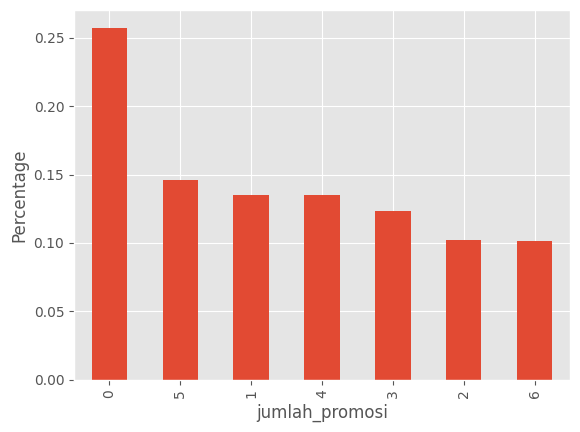

In [370]:
train['jumlah_promosi'].value_counts(normalize = True).plot(kind = 'bar')
plt.ylabel('Percentage')

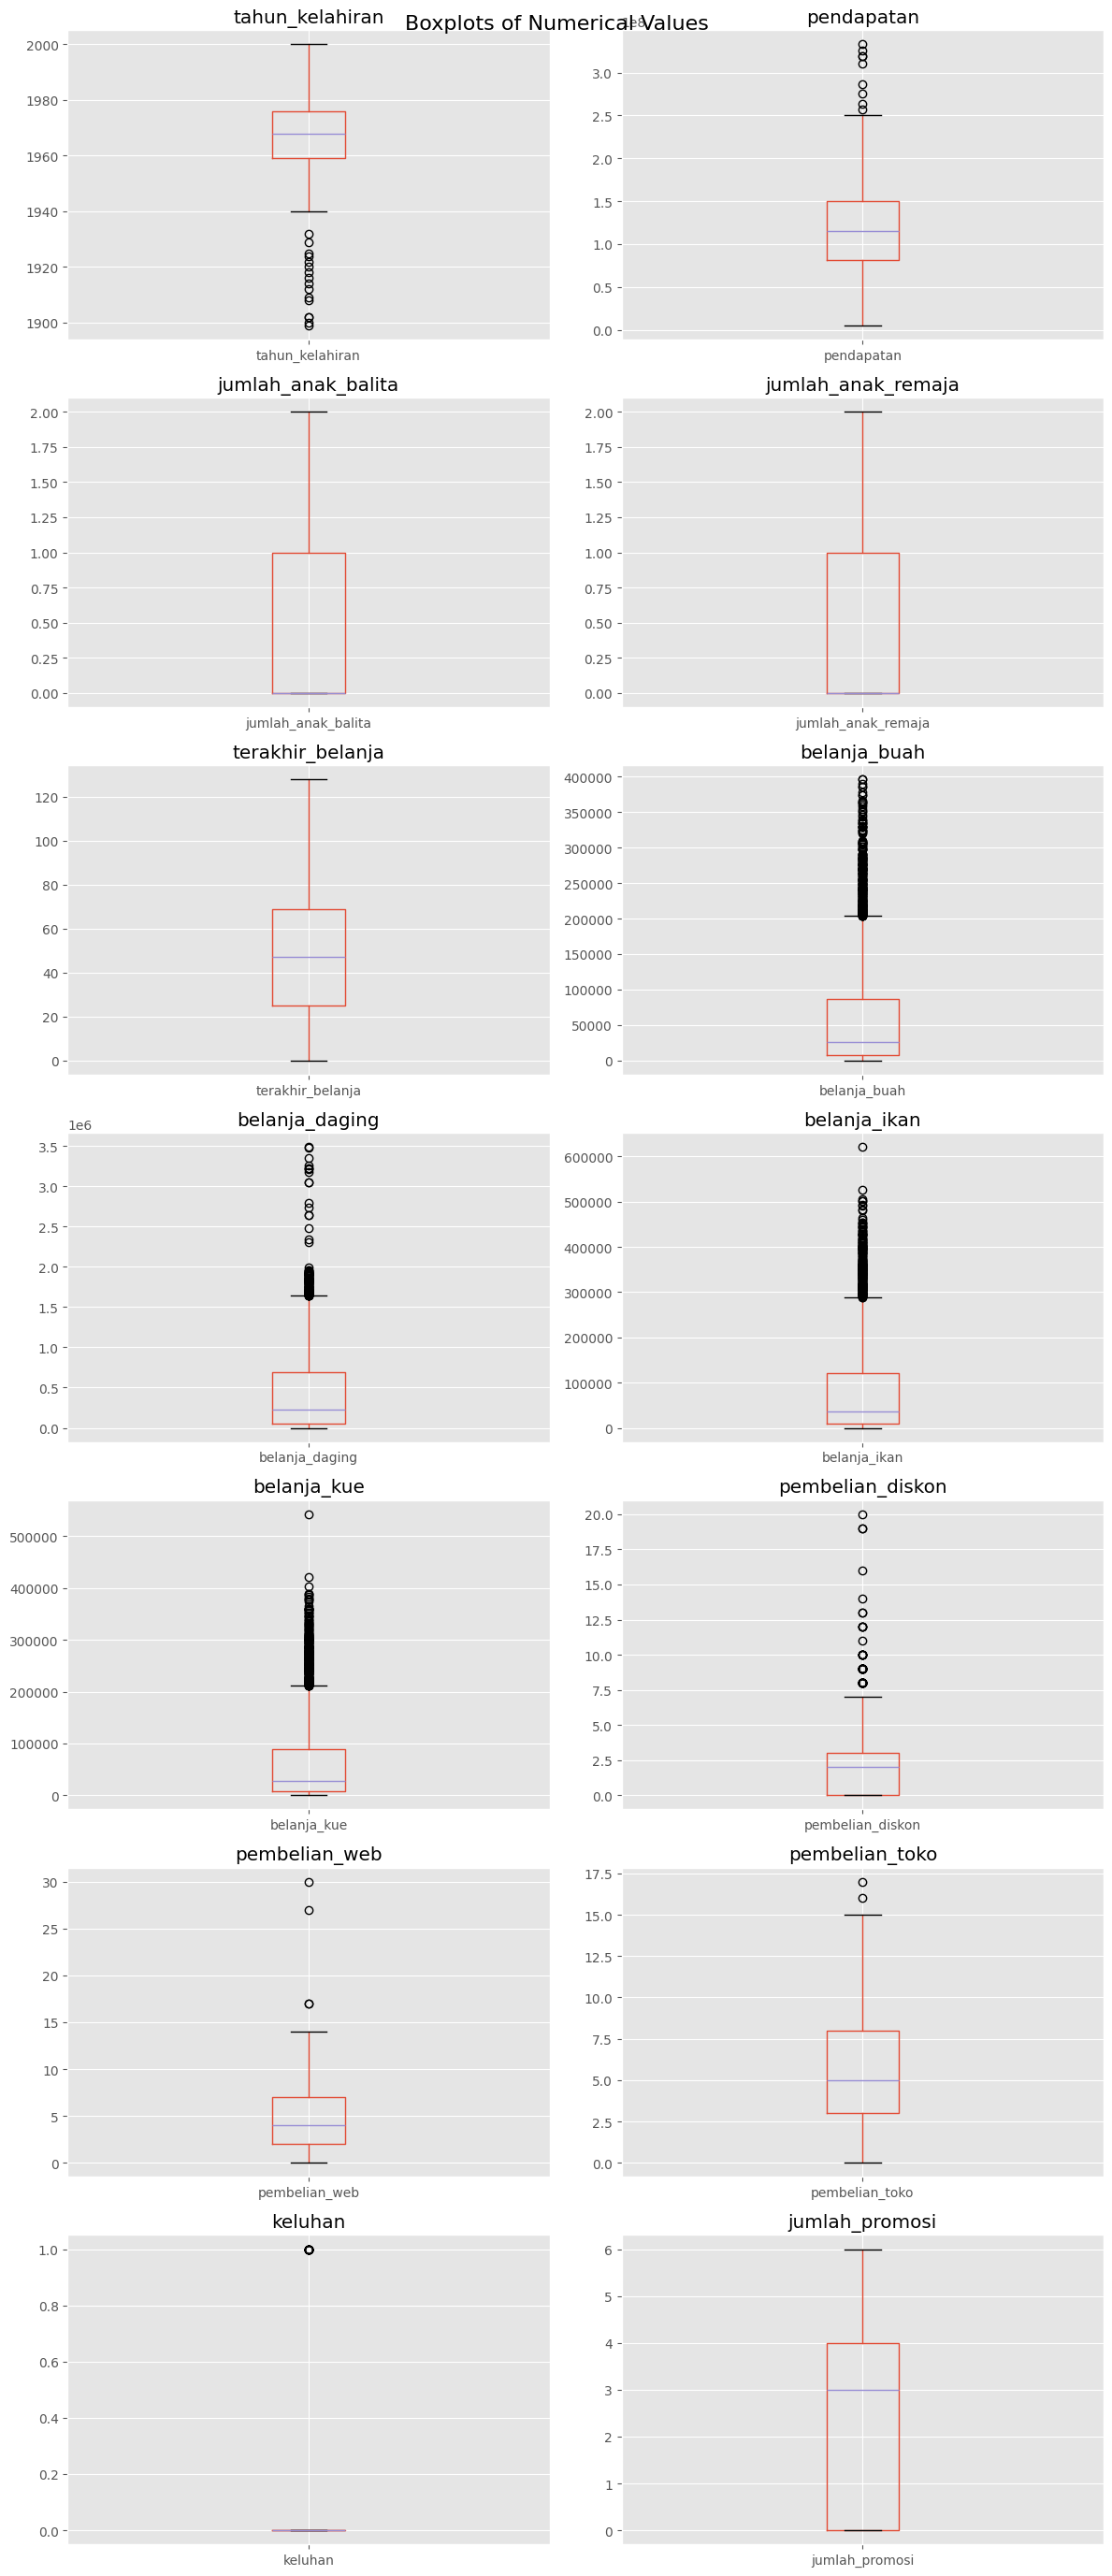

In [371]:
numerical_data = train.select_dtypes(include=[np.number])  # Select numerical columns

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    

plt.tight_layout()
plt.show()

In [372]:
table = pd.crosstab(train['pendidikan'], train['jumlah_promosi'])
table

jumlah_promosi,0,1,2,3,4,5,6
pendidikan,,,,,,,
5,2,0,0,0,0,0,0
Doktor,162,54,37,62,10,43,35
Magister,170,91,71,148,126,159,91
SMA,119,63,76,44,55,45,33
SMP,47,10,18,9,0,0,7
Sarjana,424,271,170,195,301,289,191


### Preprocessing

In [373]:
def preprocessing(df):
    df = df.drop(['tanggal_menjadi_anggota','keluhan'], axis=1)
    
    df['pendidikan'] = df['pendidikan'].map({'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5})
    df['status_pernikahan'] = df['status_pernikahan'].map({'Sendiri': 1, 'Rencana Menikah': 2, 'Menikah': 3, 'Cerai': 4, 'Cerai Mati': 5})
    
    # Pemeblian diatas 15 diubah jadi 15
    # df.loc[df['pembelian_web'] > 15, 'pembelian_web'] = 15
    # df.loc[df['pembelian_toko'] > 15, 'pembelian_toko'] = 15
    
    # Fill Null Val dengan interpolate
    df['pendapatan'] = df['pendapatan'].interpolate(method ='pad', limit_direction ='forward')
    df['terakhir_belanja'] = df['terakhir_belanja'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_buah'] = df['belanja_buah'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_daging'] = df['belanja_daging'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_ikan'] = df['belanja_ikan'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_kue'] = df['belanja_kue'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_diskon'] = df['pembelian_diskon'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_toko'] = df['pembelian_toko'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_web'] = df['pembelian_web'].interpolate(method ='pad', limit_direction ='forward')
    
    # Fill Null Val dengan median
    df = df.fillna(df.median())

    # df['jumlah_anak'] = df['jumlah_anak_remaja'] + df['jumlah_anak_balita']
    df = df.drop(['jumlah_anak_remaja','jumlah_anak_balita'], axis=1)
    
    # Gatau teori sendiri ini
    df['tahun_kelahiran'] = df['tahun_kelahiran'].apply(lambda x: x + 50 if x < 1940 else x)
    df['pendapatan'] = df['pendapatan'].apply(lambda x: x / 4 if x > 1000000000 else x)
    
    # Change data type to int64
    numerical_data = df.select_dtypes(include=[np.number])  # Select numerical columns
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].astype('int64')

    return df

In [374]:
# Preprocess train set
train = preprocessing(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,61,1940.000000,2000.000000,1968.033534,11.250294
pendidikan,int64,0,0,5,1.000000,5.000000,3.273775,0.883832
status_pernikahan,int64,0,0,5,1.000000,5.000000,2.182604,0.911107
pendapatan,int64,0,0,3622,5073000.000000,332884000.000000,114502718.265392,43535581.079180
terakhir_belanja,int64,0,0,113,0.000000,128.000000,47.165051,27.038698
belanja_buah,int64,0,0,2535,0.000000,396508.000000,59942.936861,73936.467562
belanja_daging,int64,0,0,2951,0.000000,3489675.000000,437177.892062,510953.244736
belanja_ikan,int64,0,0,2627,0.000000,621600.000000,81472.008908,100224.593805
belanja_kue,int64,0,0,2475,0.000000,542164.000000,62981.860624,78954.662837
pembelian_diskon,int64,0,0,18,0.000000,20.000000,2.126801,2.096382


In [375]:
# Preprocess test set
test = preprocessing(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,64,1940.000000,2009.000000,1968.117339,11.253241
pendidikan,int64,0,0,5,1.000000,5.000000,3.282609,0.851891
status_pernikahan,int64,0,0,5,1.000000,5.000000,2.194605,0.930997
pendapatan,int64,0,0,3610,2998899.000000,335080000.000000,115556533.160031,43063879.479422
terakhir_belanja,int64,0,0,116,0.000000,133.000000,47.076742,26.937135
belanja_buah,int64,0,0,2573,0.000000,408646.000000,61269.735726,76725.515769
belanja_daging,int64,0,0,2943,0.000000,3271191.000000,451738.129125,510561.021483
belanja_ikan,int64,0,0,2660,0.000000,574932.000000,85158.235464,103303.662294
belanja_kue,int64,0,0,2526,0.000000,532049.000000,63653.494762,78511.934217
pembelian_diskon,int64,0,0,17,0.000000,17.000000,2.105029,2.122949


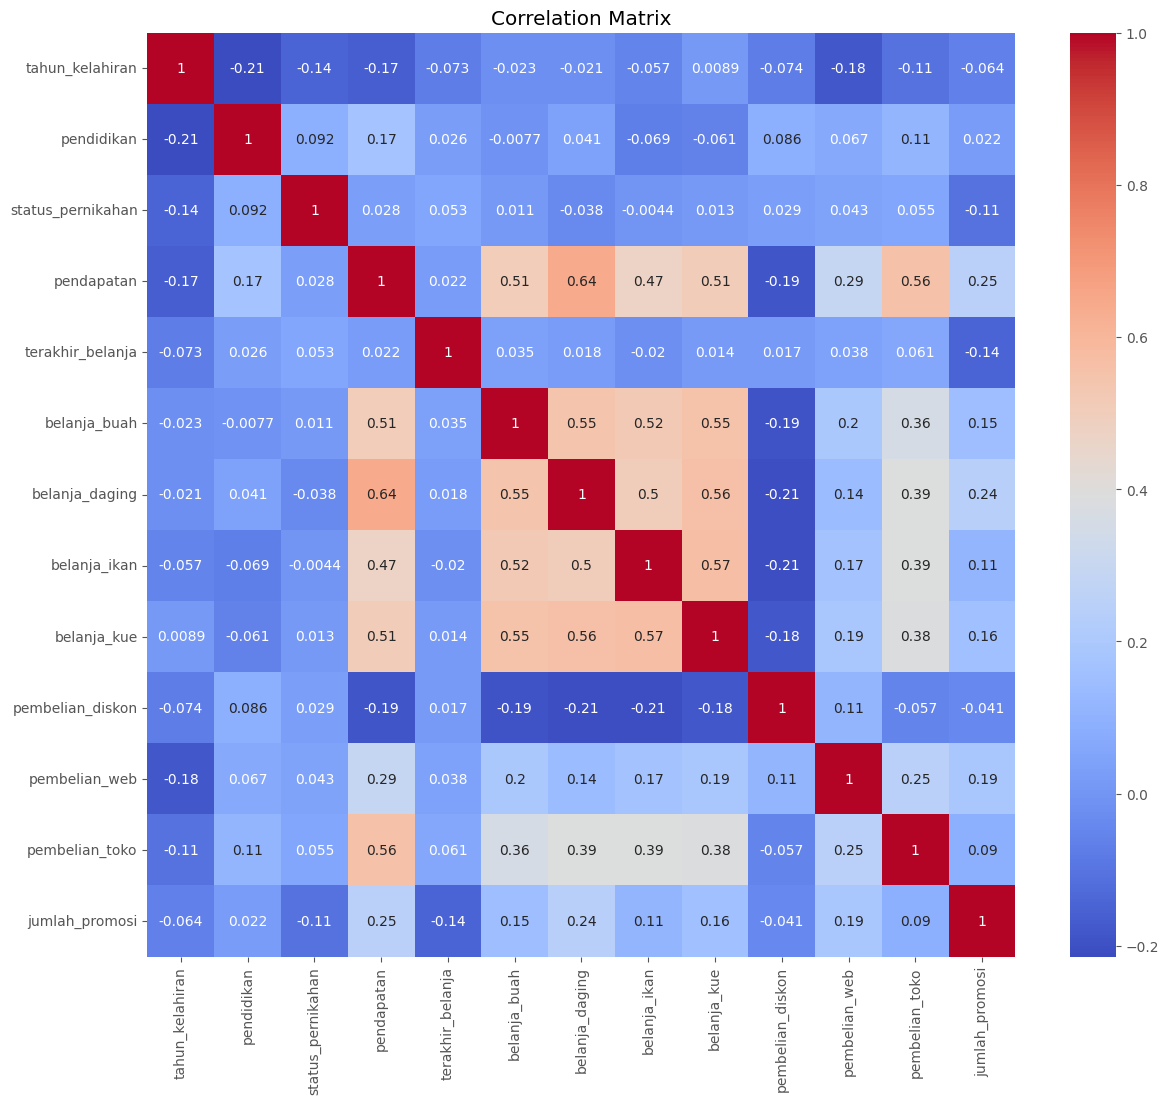

In [376]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [377]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [378]:
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning Optuna

In [379]:
# %%time
# def objective(trial):
#     # Number of trees in random forest
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

#     # Number of features to consider at every split
#     max_features = trial.suggest_int(name="max_features", low=1, high=10)

#     # Maximum number of levels in tree
#     max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

#     # Minimum number of samples required to split a node
#     min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
#     model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
#                                     min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
#                                     max_features =  max_features, random_state =  1, n_jobs =  -1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=250)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

'''
Number of finished trials:  250
Best trial:
  Value:  0.7052431826954693
  Params: 
    n_estimators: 551
    max_features: 9
    max_depth: 48
    min_samples_split: 2
    min_samples_leaf: 1
CPU times: total: 10.7 s
Wall time: 58min 56s
'''

'\nNumber of finished trials:  250\nBest trial:\n  Value:  0.7052431826954693\n  Params: \n    n_estimators: 551\n    max_features: 9\n    max_depth: 48\n    min_samples_split: 2\n    min_samples_leaf: 1\nCPU times: total: 10.7 s\nWall time: 58min 56s\n'

In [380]:
# %%time
# def objective(trial):
#     # Number of trees in random forest
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

#     # Number of features to consider at every split
#     max_features = trial.suggest_int(name="max_features", low=1, high=10)

#     # Maximum number of levels in tree
#     max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

#     # Minimum number of samples required to split a node
#     min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
#     model = ExtraTreesClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
#                                     min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
#                                     max_features =  max_features, random_state =  1, n_jobs =  -1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# # optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="extra_tree", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
    
# optuna.visualization.plot_optimization_history(study)

'''
Number of finished trials:  200
Best trial:
  Value:  0.7323791508719832
  Params: 
    n_estimators: 393
    max_features: 10
    max_depth: 46
    min_samples_split: 2
    min_samples_leaf: 1
CPU times: total: 2.38 s
Wall time: 11min 15s
'''

'\nNumber of finished trials:  200\nBest trial:\n  Value:  0.7323791508719832\n  Params: \n    n_estimators: 393\n    max_features: 10\n    max_depth: 46\n    min_samples_split: 2\n    min_samples_leaf: 1\nCPU times: total: 2.38 s\nWall time: 11min 15s\n'

In [381]:
# %%time
# def objective(trial):
#     # Number of trees in random forest
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

#     # Number of features to consider at every split
#     max_features = trial.suggest_int(name="max_features", low=1, high=10)

#     # Maximum number of levels in tree
#     max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

#     # Minimum number of samples required to split a node
#     min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
    
#     model = ExtraTreesClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
#                                     min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
#                                     max_features =  max_features, random_state =  1, n_jobs =  -1)
    
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     return np.mean(f1_scores)
  
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="extra_tree", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

    
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.visualization.plot_optimization_history(study)

'''
Number of finished trials:  200
Best trial:
  Value:  0.7635616360895068
  Params: 
    n_estimators: 965
    max_features: 10
    max_depth: 45
    min_samples_split: 2
    min_samples_leaf: 1
CPU times: total: 14min 55s
Wall time: 26min 30s
'''

'\nNumber of finished trials:  200\nBest trial:\n  Value:  0.7635616360895068\n  Params: \n    n_estimators: 965\n    max_features: 10\n    max_depth: 45\n    min_samples_split: 2\n    min_samples_leaf: 1\nCPU times: total: 14min 55s\nWall time: 26min 30s\n'

In [382]:
# %%time
# def objective(trial):
#     max_iter = trial.suggest_int(name="max_iter", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.2)
#     l2_regularization = trial.suggest_float(name='l2_regularization', low=0.0, high=10.0)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=50)
#     max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=2, high=32)
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
        
#     model = HistGradientBoostingClassifier(max_iter = max_iter, l2_regularization =  l2_regularization, loss = 'log_loss', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, max_leaf_nodes =  max_leaf_nodes, min_samples_leaf =  min_samples_leaf, 
#                                         max_bins =  255, early_stopping =  False, random_state =  1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# # optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  100
Best trial:
  Value:  0.709499535120383
  Params: 
    max_iter: 755
    learning_rate: 0.08069194222134556
    l2_regularization: 0.004071819616198791
    max_depth: 38
    max_leaf_nodes: 30
    min_samples_leaf: 4
CPU times: total: 2.38 s
Wall time: 20min 16s
'''

'\nNumber of finished trials:  100\nBest trial:\n  Value:  0.709499535120383\n  Params: \n    max_iter: 755\n    learning_rate: 0.08069194222134556\n    l2_regularization: 0.004071819616198791\n    max_depth: 38\n    max_leaf_nodes: 30\n    min_samples_leaf: 4\nCPU times: total: 2.38 s\nWall time: 20min 16s\n'

In [383]:
# %%time
# def objective(trial):
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.3)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=50)
#     subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     min_child_weight = trial.suggest_int(name="min_child_weight", low=1, high=32)
#     gamma = trial.suggest_float(name="gamma", low=0.01, high=2.0)
#     colsample_bytree = trial.suggest_float(name="colsample_bytree", low=0.01, high=1.0)
#     reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
#     reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
        
#     model = XGBClassifier(n_estimators = n_estimators, subsample =  subsample, eval_metric = 'mlogloss', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, gamma =  gamma, min_child_weight =  min_child_weight, 
#                                         reg_alpha =  reg_alpha, reg_lambda =  reg_lambda, colsample_bytree =  colsample_bytree, random_state =  1)
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     return np.mean(f1_scores)
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  200
Best trial:
  Value:  0.7550340041034833
  Params: 
    n_estimators: 437
    learning_rate: 0.04281456364813956
    max_depth: 37
    subsample: 0.9713873141935553
    min_child_weight: 1
    gamma: 0.01588808024225468
    colsample_bytree: 0.5338188218460388
    reg_alpha: 0.031261546452262146
    reg_lambda: 4.1854217769610554e-05
CPU times: total: 3.11 s
Wall time: 93min 47s
'''

'\nNumber of finished trials:  200\nBest trial:\n  Value:  0.7550340041034833\n  Params: \n    n_estimators: 437\n    learning_rate: 0.04281456364813956\n    max_depth: 37\n    subsample: 0.9713873141935553\n    min_child_weight: 1\n    gamma: 0.01588808024225468\n    colsample_bytree: 0.5338188218460388\n    reg_alpha: 0.031261546452262146\n    reg_lambda: 4.1854217769610554e-05\nCPU times: total: 3.11 s\nWall time: 93min 47s\n'

In [384]:
# %%time
# def objective(trial):
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)
#     learning_rate =  trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
#     max_depth = trial.suggest_int(name="max_depth", low=3, high=15)
#     subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     num_leaves = trial.suggest_int(name="num_leaves", low=2, high=50)
#     colsample_bytree = trial.suggest_float(name="colsample_bytree", low=0.01, high=1.0)
#     reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
#     reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
        
#     model = LGBMClassifier(n_estimators = n_estimators, subsample =  subsample, objective = 'multiclass', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, metric =  'multi_logloss', num_leaves =  num_leaves, 
#                                         reg_alpha =  reg_alpha, reg_lambda =  reg_lambda, colsample_bytree =  colsample_bytree, random_state =  1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 


# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  50
Best trial:
  Value:  0.7170836609609632
  Params: 
    n_estimators: 580
    learning_rate: 0.07411418118537871
    max_depth: 28
    subsample: 0.10711522895628599
    num_leaves: 47
    colsample_bytree: 0.6307097794921823
    reg_alpha: 7.069568444843734e-08
    reg_lambda: 2.741985916881125e-06
CPU times: total: 6.95 s
Wall time: 59min 9s
'''

'\nNumber of finished trials:  50\nBest trial:\n  Value:  0.7170836609609632\n  Params: \n    n_estimators: 580\n    learning_rate: 0.07411418118537871\n    max_depth: 28\n    subsample: 0.10711522895628599\n    num_leaves: 47\n    colsample_bytree: 0.6307097794921823\n    reg_alpha: 7.069568444843734e-08\n    reg_lambda: 2.741985916881125e-06\nCPU times: total: 6.95 s\nWall time: 59min 9s\n'

In [385]:
# %%time
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
#         'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
#         'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
#         'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
#     }
        
#     model = LGBMClassifier(**params, random_state =  1, verbose = -1)
    
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     return np.mean(f1_scores)


# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  50
Best trial:
  Value:  0.7170836609609632
  Params: 
    n_estimators: 580
    learning_rate: 0.07411418118537871
    max_depth: 28
    subsample: 0.10711522895628599
    num_leaves: 47
    colsample_bytree: 0.6307097794921823
    reg_alpha: 7.069568444843734e-08
    reg_lambda: 2.741985916881125e-06
CPU times: total: 6.95 s
Wall time: 59min 9s

Number of finished trials:  100
Best trial:
  Value:  0.7521662916645339
  Params: 
    num_leaves: 2000
    reg_alpha: 0.0014394303776950955
    reg_lambda: 0.0010085065533368821
    colsample_bytree: 0.6
    subsample: 0.7
    learning_rate: 0.02
    max_depth: 10
    min_child_samples: 13
    min_data_per_groups: 94
CPU times: total: 1d 12h 33min 39s
Wall time: 3h 31min 42s
'''

'\nNumber of finished trials:  50\nBest trial:\n  Value:  0.7170836609609632\n  Params: \n    n_estimators: 580\n    learning_rate: 0.07411418118537871\n    max_depth: 28\n    subsample: 0.10711522895628599\n    num_leaves: 47\n    colsample_bytree: 0.6307097794921823\n    reg_alpha: 7.069568444843734e-08\n    reg_lambda: 2.741985916881125e-06\nCPU times: total: 6.95 s\nWall time: 59min 9s\n\nNumber of finished trials:  100\nBest trial:\n  Value:  0.7521662916645339\n  Params: \n    num_leaves: 2000\n    reg_alpha: 0.0014394303776950955\n    reg_lambda: 0.0010085065533368821\n    colsample_bytree: 0.6\n    subsample: 0.7\n    learning_rate: 0.02\n    max_depth: 10\n    min_child_samples: 13\n    min_data_per_groups: 94\nCPU times: total: 1d 12h 33min 39s\nWall time: 3h 31min 42s\n'

In [386]:
# %%time
# def objective(trial):
#     iterations = trial.suggest_int(name="iterations", low=100, high=2000)
#     learning_rate =  trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
#     depth = trial.suggest_int(name="depth", low=1, high=16)
#     # subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     bagging_temperature = trial.suggest_float("bagging_temperature", 0, 10)
#     min_data_in_leaf = trial.suggest_int(name="min_data_in_leaf", low=1, high=50)
#     colsample_bylevel = trial.suggest_float(name="colsample_bylevel", low=0.05, high=1.0)
        
#     model = CatBoostClassifier(iterations = iterations, bagging_temperature =  bagging_temperature, depth =  depth, learning_rate =  learning_rate, 
#                                loss_function = 'MultiClass', min_data_in_leaf =  min_data_in_leaf, colsample_bylevel =  colsample_bylevel, 
#                                random_state =  1, allow_writing_files = False, silent=True)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# # optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=5)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  5
Best trial:
  Value:  0.6393961912888887
  Params: 
    iterations: 812
    learning_rate: 0.07969454818643935
    depth: 12
    bagging_temperature: 5.986584841970366
    min_data_in_leaf: 8
    colsample_bylevel: 0.19819479431939252
CPU times: total: 1.98 s
Wall time: 5min 44s
'''

'\nNumber of finished trials:  5\nBest trial:\n  Value:  0.6393961912888887\n  Params: \n    iterations: 812\n    learning_rate: 0.07969454818643935\n    depth: 12\n    bagging_temperature: 5.986584841970366\n    min_data_in_leaf: 8\n    colsample_bylevel: 0.19819479431939252\nCPU times: total: 1.98 s\nWall time: 5min 44s\n'

In [387]:
# %%time
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 500, 1500),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#     }

#     model = CatBoostClassifier(**params, random_state =  1, allow_writing_files = False, silent=True, bootstrap_type="Bernoulli")
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=60)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  60
Best trial:
  Value:  0.691564367320371
  Params: 
    iterations: 1435
    learning_rate: 0.07733642618426555
    depth: 8
    subsample: 0.9258326115101116
    colsample_bylevel: 0.462897954736155
    min_data_in_leaf: 34
CPU times: total: 18.5 s
Wall time: 1h 31min 19s
'''

'\nNumber of finished trials:  60\nBest trial:\n  Value:  0.691564367320371\n  Params: \n    iterations: 1435\n    learning_rate: 0.07733642618426555\n    depth: 8\n    subsample: 0.9258326115101116\n    colsample_bylevel: 0.462897954736155\n    min_data_in_leaf: 34\nCPU times: total: 18.5 s\nWall time: 1h 31min 19s\n'

In [388]:
# optuna.visualization.plot_optimization_history(study)

### Modelling Part 1

In [389]:
# %%time
# # LogisticRegression
# logit_cv = cross_val_score(make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'auto', max_iter = 1000)), 
#                            X, y, scoring = 'f1_macro',cv = skf, n_jobs = -1)
# print(f"The average 10-folds Macro F-Score score of the LR is {logit_cv.mean()} \n")

# # RandomForestClassifier
# RF_cv = cross_val_score(RandomForestClassifier(n_estimators = 551, max_features = 9, max_depth = 48, min_samples_split = 2,
#                                                 min_samples_leaf = 1, random_state = 1, criterion = 'log_loss', n_jobs = -1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-folds Macro F-Score of the RF is {RF_cv.mean()} \n")

# # ExtraTreesClassifier
# ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
#                                              min_samples_leaf = 1, criterion = 'log_loss', random_state = 1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

# # HistGradientBoostingClassifier
# HB_cv = cross_val_score(HistGradientBoostingClassifier(max_iter = 755, learning_rate = 0.08069194222134556, l2_regularization = 0.004071819616198791,
#                                                        max_depth = 38, max_leaf_nodes = 30, min_samples_leaf = 4, loss = 'log_loss', max_bins =  255, 
#                                                        early_stopping =  False, random_state =  1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the HB is {HB_cv.mean()} \n")

# # XGBClassifier
# XGB_cv = cross_val_score(XGBClassifier(n_estimators = 437, learning_rate = 0.04281456364813956, max_depth = 37, subsample = 0.9713873141935553,
#                       min_child_weight = 1, gamma = 0.01588808024225468, colsample_bytree = 0.5338188218460388, 
#                       reg_alpha = 0.031261546452262146, reg_lambda = 4.1854217769610554e-05, random_state =  15),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the XGB is {XGB_cv.mean()} \n")

# # LGBMClassifier
# LGBM_cv = cross_val_score(LGBMClassifier(n_estimators = 580, learning_rate = 0.07411418118537871, max_depth = 28, subsample = 0.10711522895628599,
#                                          num_leaves = 47, colsample_bytree = 0.6307097794921823, reg_alpha = 7.069568444843734e-08,
#                                          reg_lambda = 2.741985916881125e-06, random_state =  1), 
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the LGBM is {LGBM_cv.mean()} \n")

# # LGBMClassifier
# LGBM_cv = cross_val_score(LGBMClassifier(n_estimators = 2000, reg_alpha = 0.0014394303776950955, reg_lambda = 0.0010085065533368821,
#                                         colsample_bytree = 0.6, subsample = 0.7, learning_rate = 0.02, max_depth = 10, min_child_samples = 13,
#                                         num_leaves = 178, min_data_per_groups = 94, random_state =  1, verbose = -1), 
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the LGBM is {LGBM_cv.mean()} \n")

In [390]:
# %%time
# Cat_cv = cross_val_score(CatBoostClassifier(loss_function = 'MultiClass', iterations = 1435, learning_rate = 0.07733642618426555, depth = 8,
#                                             subsample = 0.9258326115101116, colsample_bylevel = 0.462897954736155, min_data_in_leaf = 34, 
#                                             verbose = False, allow_writing_files = False, task_type = 'CPU'), 
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-folds Macro F-Score of the CatBoost model is {Cat_cv.mean()}") 


In [391]:
# model_performance = pd.DataFrame()
# model_performance['Model'] = ['Logistic', 'RF', 'ET', 'Hist', 'LGBM', 'XGBoost']
# model_performance['F-Score'] = [logit_cv.mean(), RF_cv.mean(), ET_cv.mean(), HB_cv.mean(), XGB_cv.mean(), LGBM_cv.mean()]
# model_performance.style.hide()


### Modelling Part 2

In [392]:
# md1 = ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
#                                              min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

md1 = ExtraTreesClassifier(n_estimators = 965, max_features = 12, 
                        max_depth = 46, min_samples_split = 2,   min_samples_leaf = 1, criterion = 'log_loss', random_state = 42)

md2 = HistGradientBoostingClassifier(max_iter = 755, learning_rate = 0.08069194222134556, l2_regularization = 0.004071819616198791,
                                                       max_depth = 38, max_leaf_nodes = 30, min_samples_leaf = 4, loss = 'log_loss', max_bins =  255, 
                                                       early_stopping =  False, random_state =  1)

# md3 = XGBClassifier(n_estimators = 241, learning_rate = 0.027071426847753828, max_depth = 23, subsample = 0.826267822451126,
#                                        min_child_weight = 1, gamma = 0.07899077336556067, colsample_bytree = 0.7273085926052265,
#                                        reg_alpha = 0.0011669044708923562, reg_lambda = 1.7546953633442173e-05, random_state =  1)

md3 = XGBClassifier(n_estimators = 437, learning_rate = 0.04281456364813956, max_depth = 37, subsample = 0.9713873141935553,
                      min_child_weight = 1, gamma = 0.01588808024225468, colsample_bytree = 0.5338188218460388, 
                      reg_alpha = 0.031261546452262146, reg_lambda = 4.1854217769610554e-05, random_state =  15)

md4 = LGBMClassifier(n_estimators = 2000, reg_alpha = 0.0014394303776950955, reg_lambda = 0.0010085065533368821,
                    colsample_bytree = 0.6, subsample = 0.7, learning_rate = 0.02, max_depth = 10, min_child_samples = 13,
                    num_leaves = 178, min_data_per_groups = 94, random_state =  1, verbose = -1)



In [393]:
# %%time
# md1_pred, md2_pred, md3_pred = list(), list(), list()
# y_test_list = list()

# for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):

#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
#     md1.fit(X_train, y_train)
#     md1_pred.append(md1.predict_proba(X_test))
    
#     md2.fit(X_train, y_train)
#     md2_pred.append(md2.predict_proba(X_test))
    
#     md3.fit(X_train, y_train)
#     md3_pred.append(md3.predict_proba(X_test))
    
#     y_test_list.append(y_test)

In [394]:
# w1_weights, w2_weights, w3_weights = list(), list(), list()
# scores = list()

# for i in tqdm(range(0, 3000)):
    
#     w1 = np.random.random_sample(size = 1)[0]
#     w2 = np.random.random_sample(size = 1)[0]
#     w3 = np.random.random_sample(size = 1)[0]
    
#     w1_weights.append(w1)
#     w2_weights.append(w2)
#     w3_weights.append(w3)
    
#     scores_in = list()
    
#     for j in range(0, 10):
        
#         pred = w1*md1_pred[j] + w2*md2_pred[j] + w3*md3_pred[j] 
#         scores_in.append(log_loss(y_test_list[j], pred))
    
#     scores.append(np.mean(scores_in))
    
# results = pd.DataFrame()
# results['w_md1'] = w1_weights
# results['w_md2'] = w2_weights
# results['w_md3'] = w3_weights
# results['score'] = scores
# results = results.sort_values(by = 'score', ascending = True).reset_index(drop = True)
# results.head(10)

In [395]:
# %%time
# md1_fit = md1.fit(X, y)
# md2_fit = md2.fit(X, y)
# md3_fit = md3.fit(X, y)

In [396]:
# ens = (results['w_md1'][0]*md1_fit.predict_proba(test) + 
#        results['w_md2'][0]*md2_fit.predict_proba(test) + 
#        results['w_md3'][0]*md3_fit.predict_proba(test))

# ens = pd.DataFrame(ens)
# ens = ens.div(ens.sum(axis = 1), axis = 0)
# ens

In [397]:
# def get_max_col_name(row):
#   """
#   This function takes a pandas Series (row) and returns the name of the column
#   containing the maximum value.
#   """
#   # Find the index of the maximum value
#   max_index = row.idxmax()
#   return max_index

# # Apply the function to each row and create a new column 'max_col'
# ens['max_col'] = ens.apply(get_max_col_name, axis=1)

# submission_format['jumlah_promosi'] = ens['max_col']
# submission_format.to_csv('submission_d.csv',index = False)

### Modelling Part 3

In [398]:
eclf1 = VotingClassifier(estimators=[('et', md1), ('hb', md2), ('lgbm', md4), ('aaa', md3)], voting='hard')
eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))

F1:  0.7496592089424851


In [414]:
eclf3 = VotingClassifier(estimators=[('et', md4), ('lgbm', md3), ('aa', md1)], voting='soft', flatten_transform=True)
eclf3.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))

F1:  0.7551040512190111


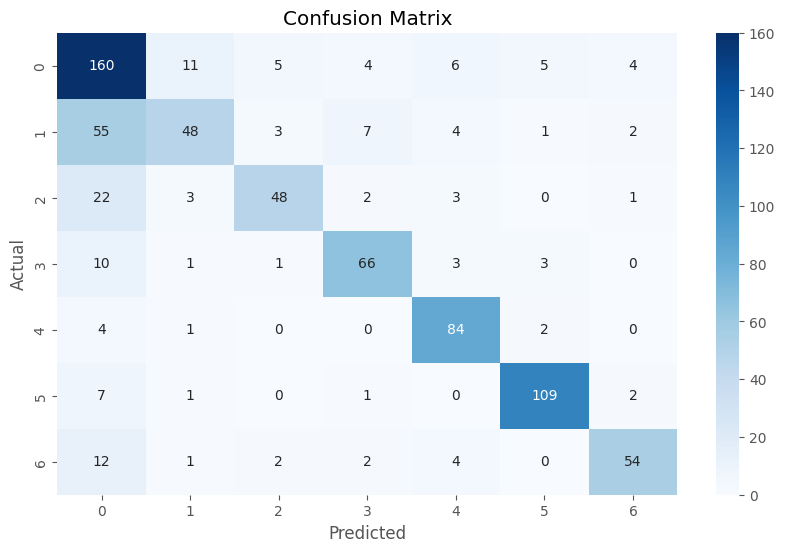

In [400]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [415]:
eclf2 = StackingClassifier(estimators=[('et', md1), ('xgb', md4), ('hb1', eclf3)])
eclf2.fit(X_train, y_train)
y_pred = eclf2.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))

F1:  0.7777954693147299


In [416]:
submission = eclf2.predict(test)
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format.to_csv('submission_d.csv',index = False)
submission_format.value_counts('jumlah_promosi')

jumlah_promosi
0    1299
5     582
4     526
3     449
6     334
2     317
1     311
Name: count, dtype: int64

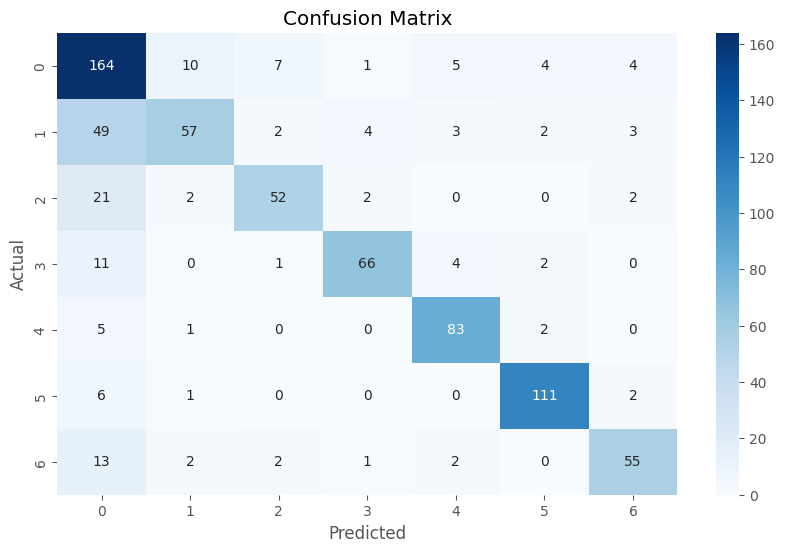

In [417]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 1.1

In [404]:
# model = RandomForestClassifier(n_estimators = 551, max_features = 9, max_depth = 48, min_samples_split = 2,
#                                                 min_samples_leaf = 1,random_state = 1, criterion = 'log_loss', n_jobs = -1)

# model = ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
#                                              min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

# num_col = ['tahun_kelahiran', 'pendidikan', 'status_pernikahan', 'pendapatan', 'terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan',
#            'belanja_kue', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko']

# stan_tran = ColumnTransformer([('stand', StandardScaler(), num_col)], remainder = 'passthrough')
# model = Pipeline([('tran', stan_tran), ('model', ExtraTreesClassifier(n_estimators = 417, max_features = 9, 
#                         max_depth = 71, min_samples_split = 3,   min_samples_leaf = 1, criterion = 'log_loss', random_state = 1))])

model = ExtraTreesClassifier(n_estimators = 965, max_features = 12, 
                        max_depth = 46, min_samples_split = 2,   min_samples_leaf = 1, criterion = 'log_loss', random_state = 42)

# model = XGBClassifier(n_estimators = 241, learning_rate = 0.027071426847753828, max_depth = 23, subsample = 0.826267822451126,
#                                        min_child_weight = 1, gamma = 0.07899077336556067, colsample_bytree = 0.7273085926052265,
#                                        reg_alpha = 0.0011669044708923562, reg_lambda = 1.7546953633442173e-05, random_state =  7)

# model = XGBClassifier(n_estimators = 437, learning_rate = 0.04281456364813956, max_depth = 37, subsample = 0.9713873141935553,
#                       min_child_weight = 1, gamma = 0.01588808024225468, colsample_bytree = 0.5338188218460388, 
#                       reg_alpha = 0.031261546452262146, reg_lambda = 4.1854217769610554e-05, random_state =  15)

# model = HistGradientBoostingClassifier(max_iter = 755, learning_rate = 0.08069194222134556, l2_regularization = 0.004071819616198791,
#                                        max_depth = 38, max_leaf_nodes = 30, min_samples_leaf = 4, loss = 'log_loss', max_bins =  255, 
#                                        early_stopping =  False, random_state =  1)

# model = LGBMClassifier(n_estimators = 2000, reg_alpha = 0.0014394303776950955, reg_lambda = 0.0010085065533368821,
#                     colsample_bytree = 0.6, subsample = 0.7, learning_rate = 0.02, max_depth = 10, min_child_samples = 13,
#                     num_leaves = 150, min_data_per_groups = 94, random_state =  1, verbose = -1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))
submission = model.predict(test)

F1:  0.7467065074288284


In [405]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve

# # Assuming you have your regression model called 'regressor' and your feature matrix 'X' and target variable 'y'

# # Create a function to plot the learning curve
# def plot_learning_curve(estimator, X, y):
#     train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=skf,
#                                                           train_sizes=np.linspace(0.1, 1.0, 10))

#     # Calculate the mean and standard deviation of the training scores
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)

#     # Calculate the mean and standard deviation of the validation scores
#     val_scores_mean = np.mean(val_scores, axis=1)
#     val_scores_std = np.std(val_scores, axis=1)

#     # Plot the learning curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2, color="r")
#     plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
#                      val_scores_mean + val_scores_std, alpha=0.2, color="g")
#     plt.xlabel("Training Set Size")
#     plt.ylabel("Score")
#     plt.title("Learning Curve")
#     plt.legend(loc="best")
#     plt.grid(True)
#     plt.show()
    
# plot_learning_curve(model, X, y)

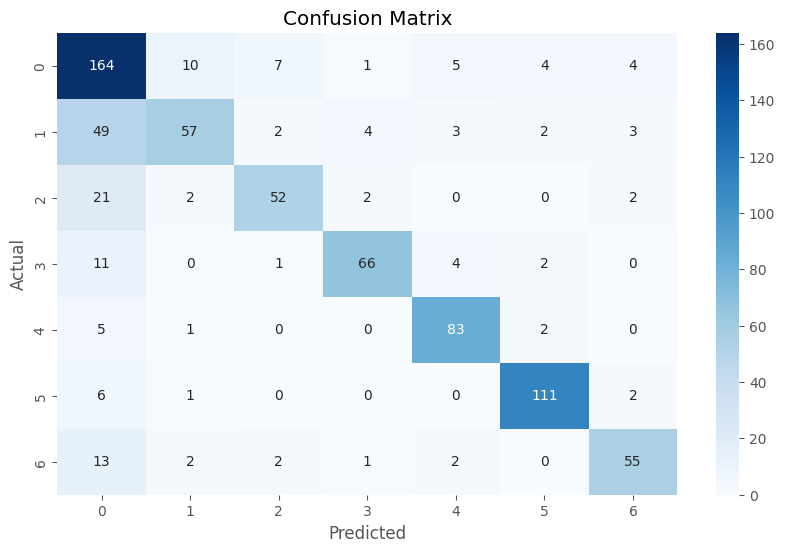

In [418]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

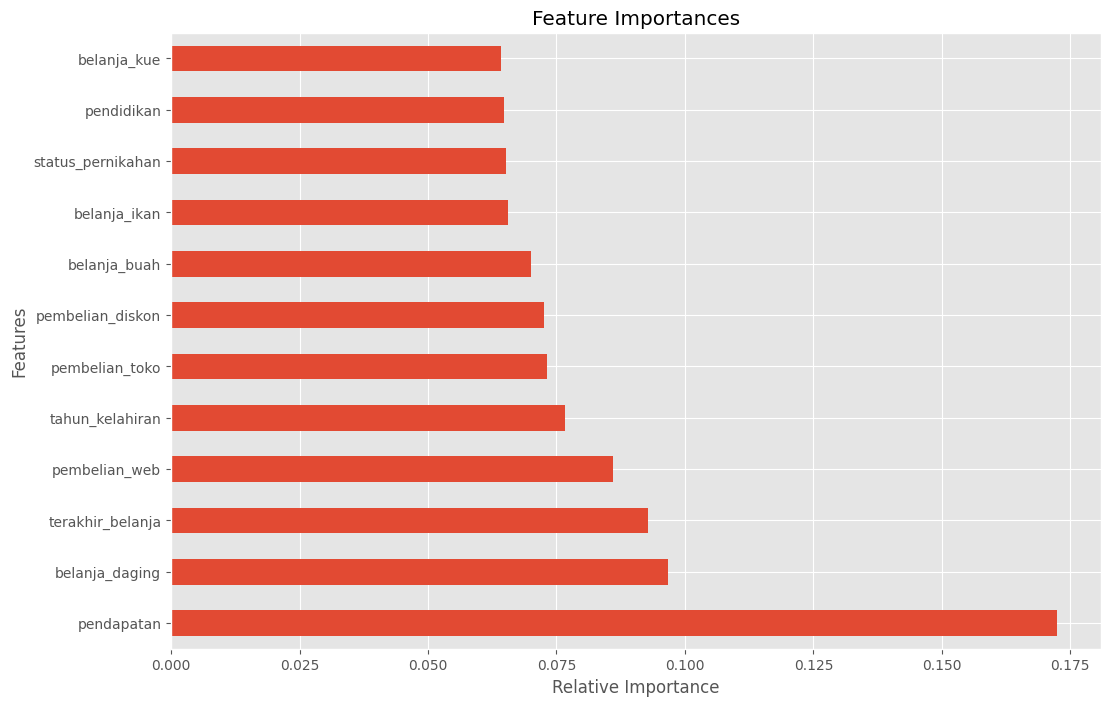

In [407]:
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [408]:
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format.to_csv('submission_d.csv',index = False)

### Modelling Part 3

In [409]:
# # Create a StandardScaler object
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)
# scaler.fit(test)
# test = scaler.transform(test)

In [410]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [411]:
# import tensorflow as tf
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential

# # Assuming your data is loaded into NumPy arrays
# # print(X.shape)  # Shape (3817, 8)
# # print(y.shape)  # Shape (3817,) - Target labels (one-hot encoded or integers)

# # Define number of classes (modify based on your actual number of classes)
# num_classes = 7  # Replace with the actual number of classes in your data

# # One-hot encode target labels if they are not already encoded
# y = tf.keras.utils.to_categorical(y, num_classes)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# # Define the model
# model = Sequential([
#   Dense(128, activation='relu', input_shape=(8,)),  # Input layer with 8 features
#   Dense(64, activation='relu'),
#   Dense(7, activation='softmax')  # Output layer with num_classes units
# ])

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

# # Train the model (adjust epochs and batch size as needed)
# history = model.fit(X_train, y_train, epochs=500, batch_size=32)

# # Evaluate the model (on separate test data for a more reliable assessment)
# loss, accuracy, f1_macro = model.evaluate(X_test, y_test)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)
# print('Test F1 Macro:', f1_macro)



In [412]:
# submission = model.predict(test)
# submission_df =  pd.DataFrame(submission)
# submission_df

In [413]:
# def get_max_col_name(row):
#   """
#   This function takes a pandas Series (row) and returns the name of the column
#   containing the maximum value.
#   """
#   # Find the index of the maximum value
#   max_index = row.idxmax()
#   return max_index

# # Apply the function to each row and create a new column 'max_col'
# submission_df['max_col'] = submission_df.apply(get_max_col_name, axis=1)

# submission_format['jumlah_promosi'] = submission_df['max_col']
# submission_format.to_csv('submission_d.csv',index = False)